# Calibrate the two cameras

In [1]:
%load_ext autoreload
%autoreload 2
# from https://github.com/niconielsen32/ComputerVision/blob/master/cameraCalibration.py
# modified
import scipy
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob
from src.calibrator import Calibrator

img_path = 'assets/calibration_new/'
np.set_printoptions(precision=9,suppress=True)

################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (7,5)
frameSize = (3648,2736)
#frameSize = (1600,1200)
size_of_chessboard_squares_mm = 29.15

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

calibrator = Calibrator(img_path, file_selector='img-*.jpg', frameSize=(3648,2736), chessboardSize=(7,5), chessboard_square_mm=29.15)


In [2]:
cameraMatrix = calibrator.calibrate()
K1 = K2 = cameraMatrix

True
True
True
True
True
True
True
True
True
True

Camera calibrated:  0.4178394466041499
Camera Matrix:  [[2790.294372464    0.          1827.292165548]
 [   0.          2794.318008548 1402.015525105]
 [   0.             0.             1.         ]]
Distortion Parameters:  [[ 0.276835049 -2.987342034  0.000200696  0.000459854  6.718396197]]
Rotation Vectors:  (array([[-0.741706646],
       [-0.008120225],
       [-0.182648646]]), array([[-0.689999998],
       [-0.0743859  ],
       [-0.096006657]]), array([[-0.624043789],
       [-0.097631426],
       [-0.298053018]]), array([[-0.761454365],
       [ 0.475764108],
       [ 1.298924242]]), array([[-0.205764957],
       [ 0.42302761 ],
       [ 1.380929914]]), array([[-0.38922491 ],
       [ 0.516165039],
       [ 1.495358733]]), array([[-0.502829282],
       [ 0.020669438],
       [-0.270155395]]), array([[-0.631370066],
       [ 0.225574234],
       [ 0.904118162]]), array([[-0.316729012],
       [ 0.553199823],
       [ 1.602964387]]

In [3]:
P, _ = calibrator.calculateProjection(3)
Pp, _ = calibrator.calculateProjection(4)

P for img-*.jpg3
[[   -650.164351044   -3128.494495281     956.319953208 1717675.643218846]
 [    906.042020235     -92.983881038    2990.702680135  695757.294986894]
 [     -0.701240357      -0.232316321       0.674011193     843.000826879]]
P for img-*.jpg4
[[   -382.254476596   -2536.676276716    2131.641228149 2242526.183899795]
 [   1956.707774324     666.187749349    2345.495519938 1220806.607190517]
 [     -0.406754642       0.103658779       0.907637328    1130.541272018]]


Tcv [[-0.804530832]
 [-0.315021218]
 [ 0.503478332]
 [-0.001158604]]
Tf [ -285755.101273007  1219855.823108599 -1365571.064576885]
Sanity (P) [[   -650.164351044   -3128.494495281     956.319953208 1717675.643218846]
 [    906.042020235     -92.983881038    2990.702680135  695757.294986894]
 [     -0.701240357      -0.232316321       0.674011193     843.000826879]]
Sanity (K) [[-6.501643510e+02 -3.128494495e+03  9.563199532e+02 -3.292638159e+09]
 [ 9.060420202e+02 -9.298388104e+01  2.990702680e+03  1.494113261e+09]
 [-7.012403572e-01 -2.323163209e-01  6.740111932e-01 -1.365571065e+06]]
C [ 694.396761321  271.897241339 -434.55602837 ]
Tcv [[ 0.499684477]
 [-0.027220456]
 [-0.865779245]
 [ 0.000877353]]
Tf [-902389.315849882 2255973.057251637 -784584.490895945]
Sanity (P) [[   -382.254476596   -2536.676276716    2131.641228149 2242526.183899795]
 [   1956.707774324     666.187749349    2345.495519938 1220806.607190517]
 [     -0.406754642       0.103658779       0.907637328    1130.54127

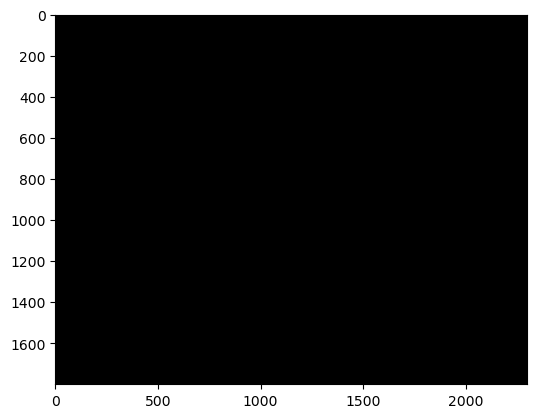

In [9]:
def factorize(P):
    M = P[:,0:3]
    
    out = cv.decomposeProjectionMatrix(P)
    K,R,T = out[0],out[1],out[2]
    K = K / K[2,2]
    print("Tcv", T)
    T = R.dot(P[:,3])
    print("Tf", T)
    
    C = np.dot(-scipy.linalg.inv(M),P[:,3])
    print("Sanity (P)", P) 
    print("Sanity (K)", K.dot(np.concatenate((R,T.reshape(-1,1)), axis=1)))
    print("C", C)
    return(K,R,C)

def plotLine(img, height, color):
    cv.line(img, (0,height), (4600,height), color, 5)

def fusiello(Mpl,Mpr, imgL_path, imgR_path, out_path=None):  
    Kl,Rl,Cl = factorize(Mpl)
    Kr,Rr,Cr = factorize(Mpr)
    print(Kl)
    print(Rl)
    print(Cl)
    x = Cl-Cr
    y = np.array(x)
    y[0]=-x[1]
    y[1]=x[0]
    z = np.cross(x,y)
    print("x", x)
    print("y", y)
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    z = z/np.linalg.norm(z)
    Rs = np.array([x,y,z])
    tls = -Rs.dot(Cl).reshape(-1,1)
    trs = -Rs.dot(Cr).reshape(-1,1)
    print("Rs", Rs)
    print(tls)
    print(trs)
    #print(Rs)
    Ks = (Kl+Kr)/2
    Ks[0,1]=0
    Mls = Ks.dot(np.concatenate((Rs, tls), axis=1))
    Mrs = Ks.dot(np.concatenate((Rs, trs), axis=1))
    print("Mrs",Mrs)
    print("Mls",Mls)
    TFusl = Ks.dot(Rs).dot(np.linalg.inv(Kl.dot(Rl)))
    TFusr = Ks.dot(Rs).dot(np.linalg.inv(Kr.dot(Rr)))
    print("TFusl",TFusl)
    print("TFusr",TFusr)
    
    imgL=cv.imread(imgL_path)
    imgL = cv.resize(imgL,(1600,1200))
    imgR=cv.imread(imgR_path)
    imgR = cv.resize(imgR,(1600,1200))
    
    #cv.warpPerspective(imgL)
    outL = cv.warpPerspective(imgL,TFusl,(2300,1800),flags=cv.INTER_LINEAR)
    outR = cv.warpPerspective(imgR,TFusr,(2300,1800),flags=cv.INTER_LINEAR)
    out = cv.hconcat([outL,outR])
    plotLine(out, 600, (255, 0, 0))
    plotLine(out, 750, (0, 0, 255))
    plotLine(out, 1000, (0, 255, 0))
    if(out_path):
        cv.imwrite(out_path, out)
    #plt.imshow(outL)
    plt.imshow(out)
    
    
fusiello(P, Pp, "assets/calibration_new/img-04.jpg", "assets/calibration_new/img-05.jpg", 'assets/fusiello.jpg')

In [29]:
Pp = np.array([[ 6.12430486e+02, -9.29557380e+02,  8.04197963e+02,
         9.98847541e+05],
       [ 8.35836177e+02,  5.46965600e+02,  6.29515656e+02,
         4.76432546e+05],
       [ 3.87999651e-04, -1.16635373e-01,  9.93174727e-01,
         7.88766677e+02]])
P = np.array([[-2.07810101e+02, -9.57532647e+02,  9.19420275e+02,
         4.99058538e+05],
       [ 6.41846643e+02,  1.77844561e+02,  9.33546842e+02,
         6.25080797e+05],
       [-3.98103114e-01,  4.43355772e-03,  9.17329959e-01,
         7.76363781e+02]])



print("P\n",P)
print("Pp\n",Pp)

P
 [[-2.07810101e+02 -9.57532647e+02  9.19420275e+02  4.99058538e+05]
 [ 6.41846643e+02  1.77844561e+02  9.33546842e+02  6.25080797e+05]
 [-3.98103114e-01  4.43355772e-03  9.17329959e-01  7.76363781e+02]]
Pp
 [[ 6.12430486e+02 -9.29557380e+02  8.04197963e+02  9.98847541e+05]
 [ 8.35836177e+02  5.46965600e+02  6.29515656e+02  4.76432546e+05]
 [ 3.87999651e-04 -1.16635373e-01  9.93174727e-01  7.88766677e+02]]
